In [1]:
from typing import List
import sys
from collections import defaultdict

import pandas as pd
import numpy as np
from tqdm.autonotebook import tqdm

from recsys4daos.models import OpenPop
from recsys4daos.datasets import to_microsoft
from recsys4daos.model_selection import cvtt_open
from recsys4daos.evaluation import calculate_all_metrics

import paths

import recommenders
if recommenders.__version__ == '1.2.0':
    print("Ignoring warnings")
    import warnings
    warnings.simplefilter(action='ignore', category=FutureWarning)

/tmp/ipykernel_3813202/2526015065.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Ignoring warnings


In [2]:
SPLITS_FREQ = "W-THU"
SPLITS_NORMALIZE = True
ORG_NAME = 'Decentraland'
LAST_FOLD_DATE_STR: str = None # Won't use it, we will just calculate for every fold

# In this notebook this is just used for plotting and description, not "training"
# every fold is saved into the results table
LAST_FOLDS = 10

K_RECOMMENDATIONS: List[int] = [1,3,5,10,15,100]

In [3]:
# Parameters
EXECUTION_ID = "2024-09-04T10:00"
ORG_NAME = "Genesis Alpha"
SPLITS_FREQ = "7d"
LAST_FOLDS = 10
SPLITS_NORMALIZE = True
LAST_FOLD_DATE_STR = "2019-12-04"


## Obtain dataset

In [4]:
!pwd

/home/daviddavo/recsys4daos/notebooks


In [5]:
!md5sum ../data/decentraland/*

md5sum: '../data/decentraland/*': No such file or directory


In [6]:
dfp = paths.load_proposals(ORG_NAME)
dfv = paths.load_votes(ORG_NAME)

df = to_microsoft(dfv)

print(dfp.info())
print(dfv.info())
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 387 entries, 0 to 386
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 387 non-null    object        
 1   author             387 non-null    object        
 2   date               387 non-null    datetime64[us]
 3   start              387 non-null    datetime64[us]
 4   end                387 non-null    datetime64[us]
 5   platform_proposal  387 non-null    object        
dtypes: datetime64[us](3), object(3)
memory usage: 18.3+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2203 entries, 0 to 2202
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   id        2203 non-null   object        
 1   proposal  2203 non-null   object        
 2   voter     2203 non-null   object        
 3   date      2203 non-null   datetime64[us]
dtypes: d

## Showing some info of the folds

In [7]:
sdd = defaultdict(list)

for dftrain, dftest, t, openproposals in cvtt_open(to_microsoft(dfv), SPLITS_FREQ, dfp.reset_index(), remove_not_in_train_col='userID', normalize=SPLITS_NORMALIZE):
    dftrain_filter = dftrain[dftrain['itemID'].isin(openproposals)]
    
    sdd['fold'].append(t)
    sdd['open proposals'].append(len(openproposals))
    
    sdd['proposals in train'].append(dftrain['itemID'].nunique())
    sdd['votes in train'].append(len(dftrain))
    sdd['votes in open proposals (train)'].append(len(dftrain_filter))
    sdd['users in open proposals (train)'].append(dftrain_filter['userID'].nunique())
    sdd['votes in test'].append(len(dftest))
    sdd['users in train'].append(dftrain['userID'].nunique())
    sdd['users in test'].append(dftest['userID'].nunique())

sdf_all = pd.DataFrame(sdd).set_index('fold')
sdf_all['vpp in open proposals (train)'] = sdf_all['votes in open proposals (train)'] / sdf_all['open proposals']
sdf_all['vpu in open proposals (train)'] = sdf_all['votes in open proposals (train)'] / sdf_all['users in open proposals (train)']
sdf_all['vpp test'] = sdf_all['votes in test'] / sdf_all['open proposals']
sdf_all['vpu test'] = sdf_all['votes in test'] / sdf_all['users in test']
paths.save_folds_info(sdf_all, ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE)
sdf = sdf_all.tail(LAST_FOLDS)
print(sdf['votes in train'])
_style = sdf[['open proposals', 'votes in open proposals (train)', 'users in open proposals (train)', 'vpp in open proposals (train)', 'vpu in open proposals (train)', 'votes in test', 'users in test', 'vpp test', 'vpu test']].style
_style = _style.format_index('{:%G-W%V}').format(precision=2)
_style

Saved dataframe into /home/daviddavo/recsys4daos/data/output/Genesis Alpha/baseline/folds-info_7d_normalize.parquet
fold
2020-10-07    2201
2020-10-14    2201
2020-10-21    2201
2020-10-28    2201
2020-11-04    2201
2020-11-11    2201
2020-11-18    2201
2020-11-25    2201
2020-12-02    2201
2020-12-09    2201
Name: votes in train, dtype: int64


,open proposals,votes in open proposals (train),users in open proposals (train),vpp in open proposals (train),vpu in open proposals (train),votes in test,users in test,vpp test,vpu test
fold,,,,,,,,,
2020-W41,0,0,0,nan,nan,0,0,nan,nan
2020-W42,0,0,0,nan,nan,0,0,nan,nan
2020-W43,0,0,0,nan,nan,0,0,nan,nan
2020-W44,0,0,0,nan,nan,0,0,nan,nan
2020-W45,0,0,0,nan,nan,0,0,nan,nan
2020-W46,0,0,0,nan,nan,0,0,nan,nan
2020-W47,0,0,0,nan,nan,0,0,nan,nan
2020-W48,0,0,0,nan,nan,0,0,nan,nan
2020-W49,0,0,0,nan,nan,0,0,nan,nan


In [8]:
print(_style
  .format_index("\\textbf{{{}}}", escape="latex", axis=1)
  .to_latex()
)

\begin{tabular}{lrrrrrrrrr}
 & \textbf{open proposals} & \textbf{votes in open proposals (train)} & \textbf{users in open proposals (train)} & \textbf{vpp in open proposals (train)} & \textbf{vpu in open proposals (train)} & \textbf{votes in test} & \textbf{users in test} & \textbf{vpp test} & \textbf{vpu test} \\
fold &  &  &  &  &  &  &  &  &  \\
2020-W41 & 0 & 0 & 0 & nan & nan & 0 & 0 & nan & nan \\
2020-W42 & 0 & 0 & 0 & nan & nan & 0 & 0 & nan & nan \\
2020-W43 & 0 & 0 & 0 & nan & nan & 0 & 0 & nan & nan \\
2020-W44 & 0 & 0 & 0 & nan & nan & 0 & 0 & nan & nan \\
2020-W45 & 0 & 0 & 0 & nan & nan & 0 & 0 & nan & nan \\
2020-W46 & 0 & 0 & 0 & nan & nan & 0 & 0 & nan & nan \\
2020-W47 & 0 & 0 & 0 & nan & nan & 0 & 0 & nan & nan \\
2020-W48 & 0 & 0 & 0 & nan & nan & 0 & 0 & nan & nan \\
2020-W49 & 0 & 0 & 0 & nan & nan & 0 & 0 & nan & nan \\
2020-W50 & 0 & 0 & 0 & nan & nan & 0 & 0 & nan & nan \\
\end{tabular}



## Running openpop baseline

In [9]:
WARNING_AT_LEAST_OPEN = 5

folds = list(cvtt_open(df, SPLITS_FREQ, dfp, remove_not_in_train_col='userID', normalize=SPLITS_NORMALIZE))
metrics = []
perfectmetrics = []

first_empty = True
ok_in_a_row = best_in_a_row = 0
max_ok_in_a_row = (-1, folds[-1].end)
for i, (train, test, t, open_proposals) in enumerate(tqdm(folds)):   
    if first_empty:
        if not train.empty:
            first_empty = False
    else:
        assert not train.empty, f"Train should not be empty on fold {i}"
    if test.empty:
        print(f"Warning, empty test fold {i} ({t}), all ok since {ok_in_a_row} folds ago", file=sys.stderr)
        if ok_in_a_row > max_ok_in_a_row[0]:
            max_ok_in_a_row = (ok_in_a_row, t)
        ok_in_a_row = best_in_a_row = 0
    elif len(open_proposals) < WARNING_AT_LEAST_OPEN:
        print(f"Warning, test fold {i} ({t}) with less than {WARNING_AT_LEAST_OPEN} open proposals ({len(open_proposals)}). all ok since {best_in_a_row} folds ago", file=sys.stderr)
        best_in_a_row = 0

    mdict = {'fold': t}
    pdict = {'fold': t}
    model = OpenPop(train)
    recs = model.recommend_k_items(test['userID'].unique(), max(K_RECOMMENDATIONS), recommend_from=open_proposals)
    mdict |= calculate_all_metrics(test, recs, K_RECOMMENDATIONS)
        # for m, f in metrics_f.items():
        #     r = f(test, recs, k=k_recs)
        #     metrics[m+f'@{k_recs}'].append(r)
    
    recs = test.copy()
    recs['prediction'] = 1
    pdict |= calculate_all_metrics(test, recs, K_RECOMMENDATIONS)

        # for m, f in metrics_f.items():
        #     # Need relevancy_method=None as they are unsorted
        #     r = f(test, recs, k=k_recs)
        #     perfectmetrics[m+f'@{k_recs}'].append(r)

    metrics.append(mdict)
    perfectmetrics.append(pdict)
    ok_in_a_row += 1
    best_in_a_row += 1

paths.save_dao_datum(ORG_NAME, 'max_ok_folds', str(max_ok_in_a_row[0]))
paths.save_dao_datum(ORG_NAME, 'max_ok_folds_date', str(max_ok_in_a_row[1]))
if max_ok_in_a_row == -1:
    print("All ok :>")
else:
    print("Max ok in a row:", max_ok_in_a_row)

  0%|          | 0/88 [00:00<?, ?it/s]

Warning, empty test fold 0 (2019-04-10 00:00:00), all ok since 0 folds ago


Warning, test fold 43 (2020-02-05 00:00:00) with less than 5 open proposals (4). all ok since 43 folds ago


Warning, empty test fold 44 (2020-02-12 00:00:00), all ok since 44 folds ago
Warning, empty test fold 45 (2020-02-19 00:00:00), all ok since 1 folds ago


Warning, test fold 46 (2020-02-26 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 47 (2020-03-04 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 48 (2020-03-11 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 49 (2020-03-18 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, empty test fold 50 (2020-03-25 00:00:00), all ok since 5 folds ago
Warning, test fold 51 (2020-04-01 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 52 (2020-04-08 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 53 (2020-04-15 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago
Warning, test fold 54 (2020-04-22 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 55 (2020-04-29 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 56 (2020-05-06 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 57 (2020-05-13 00:00:00), all ok since 7 folds ago
Warning, empty test fold 58 (2020-05-20 00:00:00), all ok since 1 folds ago


Warning, empty test fold 59 (2020-05-27 00:00:00), all ok since 1 folds ago
Warning, empty test fold 60 (2020-06-03 00:00:00), all ok since 1 folds ago


Warning, empty test fold 61 (2020-06-10 00:00:00), all ok since 1 folds ago
Warning, empty test fold 62 (2020-06-17 00:00:00), all ok since 1 folds ago


Warning, empty test fold 63 (2020-06-24 00:00:00), all ok since 1 folds ago
Warning, empty test fold 64 (2020-07-01 00:00:00), all ok since 1 folds ago


Warning, empty test fold 65 (2020-07-08 00:00:00), all ok since 1 folds ago
Warning, empty test fold 66 (2020-07-15 00:00:00), all ok since 1 folds ago


Warning, empty test fold 67 (2020-07-22 00:00:00), all ok since 1 folds ago
Warning, empty test fold 68 (2020-07-29 00:00:00), all ok since 1 folds ago


Warning, empty test fold 69 (2020-08-05 00:00:00), all ok since 1 folds ago
Warning, empty test fold 70 (2020-08-12 00:00:00), all ok since 1 folds ago


Warning, empty test fold 71 (2020-08-19 00:00:00), all ok since 1 folds ago
Warning, empty test fold 72 (2020-08-26 00:00:00), all ok since 1 folds ago


Warning, empty test fold 73 (2020-09-02 00:00:00), all ok since 1 folds ago
Warning, empty test fold 74 (2020-09-09 00:00:00), all ok since 1 folds ago


Warning, empty test fold 75 (2020-09-16 00:00:00), all ok since 1 folds ago
Warning, empty test fold 76 (2020-09-23 00:00:00), all ok since 1 folds ago


Warning, empty test fold 77 (2020-09-30 00:00:00), all ok since 1 folds ago
Warning, empty test fold 78 (2020-10-07 00:00:00), all ok since 1 folds ago


Warning, empty test fold 79 (2020-10-14 00:00:00), all ok since 1 folds ago
Warning, empty test fold 80 (2020-10-21 00:00:00), all ok since 1 folds ago


Warning, empty test fold 81 (2020-10-28 00:00:00), all ok since 1 folds ago
Warning, empty test fold 82 (2020-11-04 00:00:00), all ok since 1 folds ago


Warning, empty test fold 83 (2020-11-11 00:00:00), all ok since 1 folds ago
Warning, empty test fold 84 (2020-11-18 00:00:00), all ok since 1 folds ago


Warning, empty test fold 85 (2020-11-25 00:00:00), all ok since 1 folds ago
Warning, empty test fold 86 (2020-12-02 00:00:00), all ok since 1 folds ago


Max ok in a row: (44, Timestamp('2020-02-12 00:00:00'))


Warning, empty test fold 87 (2020-12-09 00:00:00), all ok since 1 folds ago


### Caching these results

In [10]:
odf = pd.DataFrame(metrics).set_index("fold")
paths.save_openpop(odf, ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE)
odf.describe()

Saved dataframe into /home/daviddavo/recsys4daos/data/output/Genesis Alpha/baseline/openpop_7d_normalize.parquet


,precision@1,precision@3,precision@5,precision@10,precision@15,precision@100,ndcg@1,ndcg@3,ndcg@5,ndcg@10,...,recall@10,recall@15,recall@100,r-precision@1,r-precision@3,r-precision@5,r-precision@10,r-precision@15,r-precision@100,time_eval
count,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,...,88.000000,88.000000,88.000000,88.000000,85.000000,84.000000,83.000000,83.000000,83.000000,88.000000
mean,0.159636,0.093227,0.079475,0.058867,0.044832,0.007356,0.153954,0.185062,0.215264,0.253580,...,0.383083,0.431289,0.460439,0.248673,0.300356,0.316039,0.327295,0.327527,0.327527,0.100508
std,0.303228,0.121794,0.088199,0.060012,0.045448,0.007733,0.291769,0.299762,0.305399,0.312432,...,0.405909,0.426902,0.440355,0.370078,0.357491,0.359987,0.360853,0.360831,0.360831,0.027930
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.068275
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.069640
50%,0.000000,0.021135,0.028428,0.054658,0.050772,0.009321,0.000000,0.027270,0.052844,0.124083,...,0.276629,0.354631,0.572985,0.000000,0.000000,0.197218,0.283997,0.288889,0.288889,0.115859
75%,0.160088,0.147549,0.174026,0.100000,0.077339,0.012365,0.160088,0.186280,0.301955,0.439741,...,0.765357,0.875947,0.920518,0.437500,0.508333,0.550000,0.550000,0.550000,0.550000,0.127474
max,1.000000,0.411765,0.247059,0.211111,0.174074,0.038333,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.135842


In [11]:
pdf = pd.DataFrame(perfectmetrics).set_index("fold")
cols = [ c for c in pdf.columns if not c.startswith('time_') ]
paths.save_perfect(pdf, ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE)
display(pdf.describe())
msk = (0 <= pdf[cols].min()) & (pdf[cols].max() <= 1)
if not all(msk):
    display(pdf.describe()[msk[~msk].index])
assert all( msk ), "There are metrics with wrong range"

Saved dataframe into /home/daviddavo/recsys4daos/data/output/Genesis Alpha/baseline/perfect_7d_normalize.parquet


,precision@1,precision@3,precision@5,precision@10,precision@15,precision@100,ndcg@1,ndcg@3,ndcg@5,ndcg@10,...,recall@10,recall@15,recall@100,r-precision@1,r-precision@3,r-precision@5,r-precision@10,r-precision@15,r-precision@100,time_eval
count,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,...,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000
mean,0.602273,0.299502,0.193361,0.099044,0.066155,0.009923,0.602273,0.602273,0.602273,0.602273,...,0.602127,0.602273,0.602273,0.476939,0.585669,0.599189,0.602127,0.602273,0.602273,0.106832
std,0.492233,0.264589,0.176858,0.092835,0.062291,0.009344,0.492233,0.492233,0.492233,0.492233,...,0.492116,0.492233,0.492233,0.409270,0.479658,0.489845,0.492116,0.492233,0.492233,0.027653
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.072390
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.073360
50%,1.000000,0.333333,0.200000,0.100000,0.066667,0.010000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,0.633020,0.943651,0.991402,1.000000,1.000000,1.000000,0.126680
75%,1.000000,0.526316,0.337632,0.168816,0.112544,0.016882,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,0.848500,1.000000,1.000000,1.000000,1.000000,1.000000,0.129635
max,1.000000,0.805556,0.611111,0.383333,0.266667,0.040000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.136954


## Plotting some graphs

,fold,precision@1,precision@3,precision@5,precision@10,precision@15,precision@100,ndcg@1,ndcg@3,ndcg@5,...,recall@100,r-precision@1,r-precision@3,r-precision@5,r-precision@10,r-precision@15,r-precision@100,time_eval,perfect precision@5,perfect precision@10
count,88,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,...,88.000000,88.000000,85.000000,84.000000,83.000000,83.000000,83.000000,88.000000,0.0,0.0
mean,2020-02-08 12:00:00,0.159636,0.093227,0.079475,0.058867,0.044832,0.007356,0.153954,0.185062,0.215264,...,0.460439,0.248673,0.300356,0.316039,0.327295,0.327527,0.327527,0.100508,NaN,NaN
min,2019-04-10 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.068275,NaN,NaN
25%,2019-09-09 06:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.069640,NaN,NaN
50%,2020-02-08 12:00:00,0.000000,0.021135,0.028428,0.054658,0.050772,0.009321,0.000000,0.027270,0.052844,...,0.572985,0.000000,0.000000,0.197218,0.283997,0.288889,0.288889,0.115859,NaN,NaN
75%,2020-07-09 18:00:00,0.160088,0.147549,0.174026,0.100000,0.077339,0.012365,0.160088,0.186280,0.301955,...,0.920518,0.437500,0.508333,0.550000,0.550000,0.550000,0.550000,0.127474,NaN,NaN
max,2020-12-09 00:00:00,1.000000,0.411765,0.247059,0.211111,0.174074,0.038333,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.135842,NaN,NaN
std,NaN,0.303228,0.121794,0.088199,0.060012,0.045448,0.007733,0.291769,0.299762,0.305399,...,0.440355,0.370078,0.357491,0.359987,0.360853,0.360831,0.360831,0.027930,NaN,NaN


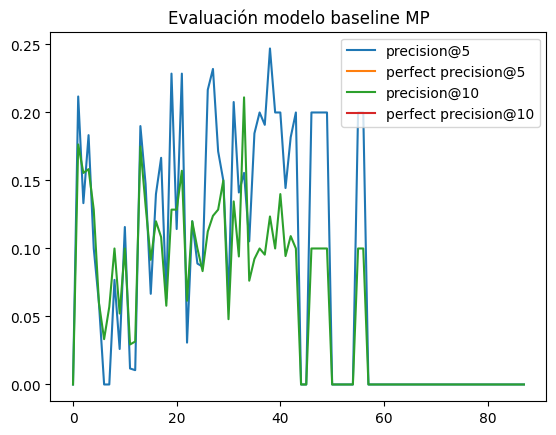

In [12]:
mdf = pd.DataFrame(metrics)
mdf['perfect precision@5'] = pdf['precision@5']
mdf['perfect precision@10'] = pdf['precision@10']
mdf[['precision@5', 'perfect precision@5', 'precision@10', 'perfect precision@10']].plot(title='Evaluación modelo baseline MP')
mdf.describe()

In [13]:
mdf[-LAST_FOLDS:].describe()

,fold,precision@1,precision@3,precision@5,precision@10,precision@15,precision@100,ndcg@1,ndcg@3,ndcg@5,...,recall@100,r-precision@1,r-precision@3,r-precision@5,r-precision@10,r-precision@15,r-precision@100,time_eval,perfect precision@5,perfect precision@10
count,10,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,...,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.000000,0.0,0.0
mean,2020-11-07 12:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.069112,NaN,NaN
min,2020-10-07 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.068275,NaN,NaN
25%,2020-10-22 18:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.068708,NaN,NaN
50%,2020-11-07 12:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.069162,NaN,NaN
75%,2020-11-23 06:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.069381,NaN,NaN
max,2020-12-09 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.070209,NaN,NaN
std,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000594,NaN,NaN
